## Homework 6 - Shakespear's Plays Analysis.
### Name: Sharjil Khan


- [1. Library Imports](#import)
- [2. Load Data](#load)
- [3. Initial Data exploration](#explore)
    - Look for Nans and the structure of the Data
- [4. A quick graph of characters](#graph)
    - A first look at what a graph might look like
- [5. Classes for pipeline](#classes)
    - Create some classes to remove nans, converge the data to more usable formats etc.
- [6. Data Prep- Execute Pipeline](#execute)
    - Execute the data prep pipeline to prepare the data for use
- [7. Charecter Networks](#plots)
    - Create Networks between Players for each Play
- [8. Pandas Frame with Centralities](#centralities)
    - Get Centrality Measures for each play and create the data frames
- [9. Apply Isolation Forest](#isolation)
    - Check to see wich Plays shows up as outliers using the centrality numbers
- [10. PCA and TSNE Plot to Plot the data](#tsne)
    - Try some PCA and TSNE Plots to reduce the dimensions and visualise the data
- [11. Outliers Using TFIDF](#tfidf)
    - Use TFIDF and CountVectorizers to see if the outliers match with the ones from Players Network Analysis.


<a id='import'></a>
# 1. LIBRARY IMPORTS 

In [1]:
import networkx as nx #pip install networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from itertools import combinations
from datetime import datetime
from time import time
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords  #pip install nltk
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
from nltk.stem.porter import PorterStemmer
import string
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from gensim.models import word2vec  #pip install word2vec
from wordcloud import WordCloud  #pip install wordcloud
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import NMF, LatentDirichletAllocation
from textblob import TextBlob  #Sentiment Analysis - pip install textblob
from sklearn.decomposition import TruncatedSVD, NMF
import matplotlib.patches as mpatches
import matplotlib
path_to_csv = '../../../cs82_advanced_machine_learning_data/HW2/papers.csv'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khan_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.style

from matplotlib.colors import ListedColormap

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
dark2_cmap = ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 12
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

import seaborn as sns 
current_palette = sns.color_palette("Set2")

mpl.style.use('seaborn')  

<a id='load'></a>
# 2. LOAD DATA FROM CSV AND INITIAL DATA EXPLORATION 

In [3]:
df_allPlays = pd.read_csv('Shakespeare_data.csv')
print(df_allPlays.shape)
df_allPlays.head()

(111396, 6)


Dataline      Play  PlayerLinenumber ActSceneLine         Player  \
0         1  Henry IV               NaN          NaN            NaN   
1         2  Henry IV               NaN          NaN            NaN   
2         3  Henry IV               NaN          NaN            NaN   
3         4  Henry IV               1.0        1.1.1  KING HENRY IV   
4         5  Henry IV               1.0        1.1.2  KING HENRY IV   

                                          PlayerLine  
0                                              ACT I  
1                       SCENE I. London. The palace.  
2  Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
3             So shaken as we are, so wan with care,  
4         Find we a time for frighted peace to pant,

<a id='explore'></a>
# 3. Explore Data- Look at NaNs and figure out where they exist and make a plan on how to deal with them

In [4]:
df_allPlays.isna().sum()

Dataline               0
Play                   0
PlayerLinenumber       3
ActSceneLine        6243
Player                 7
PlayerLine             0
dtype: int64

In [5]:
df_allPlays[df_allPlays.isnull().any(axis=1)].head()

Dataline      Play  PlayerLinenumber ActSceneLine        Player  \
0           1  Henry IV               NaN          NaN           NaN   
1           2  Henry IV               NaN          NaN           NaN   
2           3  Henry IV               NaN          NaN           NaN   
111       112  Henry IV              10.0          NaN  WESTMORELAND   
112       113  Henry IV              10.0          NaN  WESTMORELAND   

                                            PlayerLine  
0                                                ACT I  
1                         SCENE I. London. The palace.  
2    Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
111                                             Exeunt  
112    SCENE II. London. An apartment of the Prince's.

In [6]:
df_allPlays.ActSceneLine.isnull().groupby([df_allPlays['Play']]).sum()

Play
A Comedy of Errors           88.0
A Midsummer nights dream    138.0
A Winters Tale              125.0
Alls well that ends well    158.0
Antony and Cleopatra        297.0
As you like it              145.0
Coriolanus                  224.0
Cymbeline                   201.0
Hamlet                      224.0
Henry IV                    161.0
Henry V                     162.0
Henry VI Part 1             206.0
Henry VI Part 2             204.0
Henry VI Part 3             199.0
Henry VIII                  140.0
Julius Caesar               174.0
King John                   117.0
King Lear                   266.0
Loves Labours Lost          108.0
Measure for measure         158.0
Merchant of Venice          137.0
Merry Wives of Windsor      217.0
Much Ado about nothing      120.0
Othello                     199.0
Pericles                    169.0
Richard II                  137.0
Richard III                 236.0
Romeo and Juliet            217.0
Taming of the Shrew         169.0
The Tempe

<a id='graph'></a>
# 4. A quick Graph to see the interaction between players between plays to make a plan on how the interaction could be used in the analysis

Name: 
Type: Graph
Number of nodes: 971
Number of edges: 1328
Average degree:   2.7353


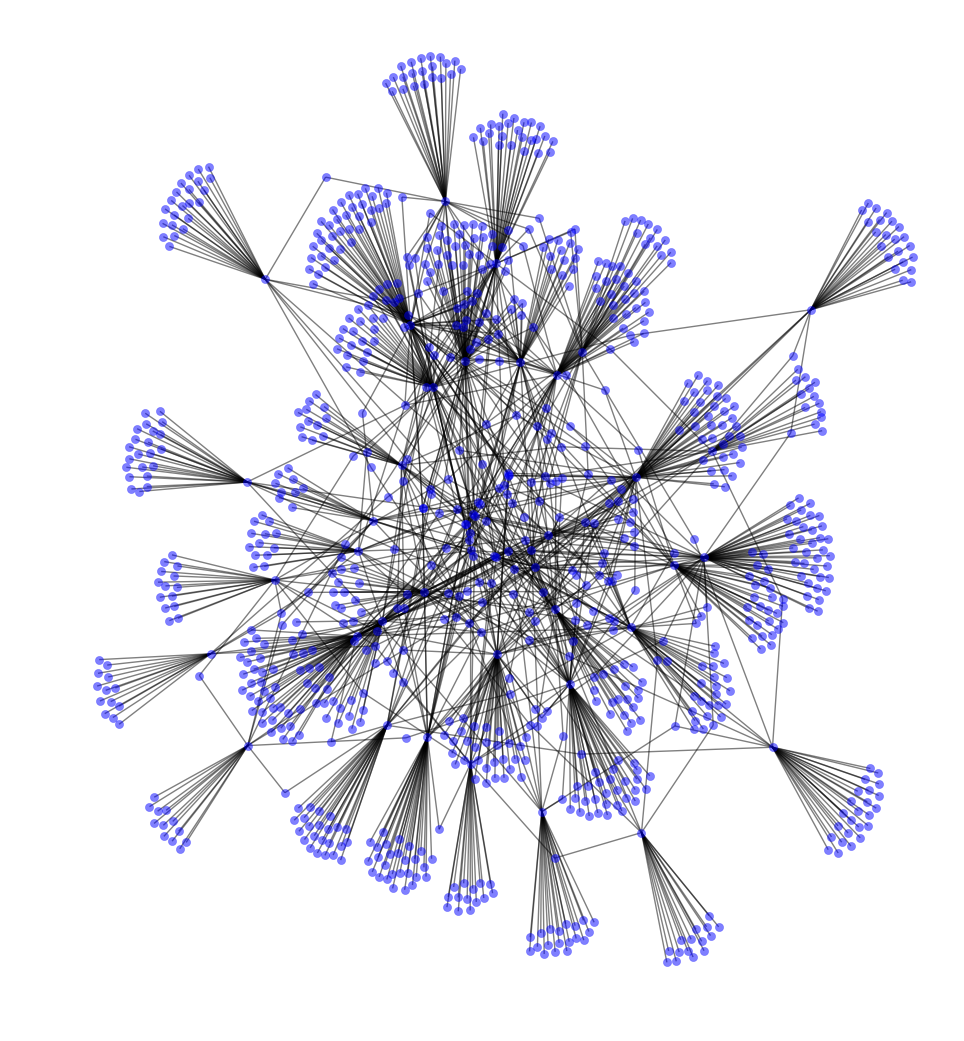

In [7]:
Graphx= nx.Graph()
Graphx = nx.from_pandas_edgelist(df_allPlays,source='Play',target='Player')
print (nx.info(Graphx))
plt.figure(figsize=(9,10)) 
nx.draw(Graphx,alpha=0.5, node_color="blue",with_labels=False,node_size=35)
plt.show()

<a id='classes'></a>
# 5. The class definations that can be executed in the pipeline to prepare the data for analysis

In [8]:
# Removes all NANs from the dataset
class RemoveAllNans (TransformerMixin, BaseEstimator):
    def __init__(self, prints = False):
        self.prints = prints
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X.dropna()
    
# Splits the ACts Scenes and Lines into seperate columns to be used as appropriate    
class split_act_scene_line (TransformerMixin, BaseEstimator):
    def __init__(self, prints = False):
        self.prints = prints
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        X[['Act','Scene','Line']] = X['ActSceneLine'].str.split('.', expand=True).apply(pd.to_numeric)
        return X
    
# Groups the data according to Play, Act or Scene depending on the choise of "grouping" variable
class group_data(TransformerMixin, BaseEstimator):
    def __init__(self, grouping = "Act",  prints = False):
        self.prints = prints
        self.grouping = grouping
        print(self.grouping)
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        if self.grouping == "Play" : 
                group_by = ["Play"]
        elif self.grouping == "Act" : 
                group_by = ["Play", "Act"]
        elif self.grouping == "Scene":
                group_by = ["Play", "Act", "Scene"] 
        lines = X.groupby(group_by)["PlayerLine"].sum().reset_index()["PlayerLine"]
        f = lambda x : list(combinations(x.values,2))
        players = X.groupby(group_by)["Player"].apply(f).reset_index()
        #players = X.groupby(group_by)["Player"].unique().reset_index()
        X_new = pd.concat([players, lines], axis=1)
        X_new = X_new.rename(columns={'Player': 'Players'})
        return X_new
    
# Converts everything to alphanumeric in case there are special charecters and also converst to lower case
class alphanumeric_lowercase(TransformerMixin, BaseEstimator):
    def __init__(self, prints = False):
        self.prints = prints
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        #Lower Case
        #X.loc[:,'Player'] = X.Player.apply(lambda x : [s.lower() for s in x])
        X.loc[:,'PlayerLine'] = X.PlayerLine.apply(lambda x: x.lower())
        #Alphanumeric
        regex = re.compile(r'\W+')
        #X.loc[:,'Player'] = X.Player.apply(lambda x: regex.sub(' ', x))
        X.loc[:,'PlayerLine'] = X.PlayerLine.apply(lambda x: regex.sub(' ', x))
        return X
    

<a id='execute'></a>
# 6. Execute the Pipeline to prepare the data

In [9]:
GROUPING = "Scene"  # Change to "Play", "Act" or "Scene" to change what each row should represent

allplays_pipeline = Pipeline([
    ('romove_na', RemoveAllNans()),
    ('split_act_scene_line', split_act_scene_line()),
    ('group_data', group_data(grouping=GROUPING)),
    ('alphanumeric', alphanumeric_lowercase())
])

df_PlayData = allplays_pipeline.fit_transform(df_allPlays)

#df_PlayData['Player'][0]
df_PlayData.head()

Scene


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Play  Act  Scene  \
0  A Comedy of Errors    1      1   
1  A Comedy of Errors    1      2   
2  A Comedy of Errors    2      1   
3  A Comedy of Errors    2      2   
4  A Comedy of Errors    3      1   

                                             Players  \
0  [(AEGEON, AEGEON), (AEGEON, DUKE SOLINUS), (AE...   
1  [(First Merchant, First Merchant), (First Merc...   
2  [(ADRIANA, ADRIANA), (ADRIANA, ADRIANA), (ADRI...   
3  [(LUCIANA, OF SYRACUSE), (LUCIANA, OF SYRACUSE...   
4  [(LUCIANA, OF EPHESUS), (LUCIANA, OF EPHESUS),...   

                                          PlayerLine  
0  proceed solinus to procure my falland by the d...  
1  therefore give out you are of epidamnum lest t...  
2  neither my husband nor the slave return d that...  
3  antipholusthe gold i gave to dromio is laid up...  
4  antipholusgood signior angelo you must excuse ...

In [10]:
GROUPING = "Scene"  # Change to "Play", "Act" or "Scene" to change what each row should represent

allplays_pipeline = Pipeline([
    ('romove_na', RemoveAllNans()),
    ('split_act_scene_line', split_act_scene_line()),
    ('group_data', group_data(grouping=GROUPING)),
    ('alphanumeric', alphanumeric_lowercase())
])

df_PlayData = allplays_pipeline.fit_transform(df_allPlays)

#df_PlayData['Player'][0]
df_PlayData.head()

Scene


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Play  Act  Scene  \
0  A Comedy of Errors    1      1   
1  A Comedy of Errors    1      2   
2  A Comedy of Errors    2      1   
3  A Comedy of Errors    2      2   
4  A Comedy of Errors    3      1   

                                             Players  \
0  [(AEGEON, AEGEON), (AEGEON, DUKE SOLINUS), (AE...   
1  [(First Merchant, First Merchant), (First Merc...   
2  [(ADRIANA, ADRIANA), (ADRIANA, ADRIANA), (ADRI...   
3  [(LUCIANA, OF SYRACUSE), (LUCIANA, OF SYRACUSE...   
4  [(LUCIANA, OF EPHESUS), (LUCIANA, OF EPHESUS),...   

                                          PlayerLine  
0  proceed solinus to procure my falland by the d...  
1  therefore give out you are of epidamnum lest t...  
2  neither my husband nor the slave return d that...  
3  antipholusthe gold i gave to dromio is laid up...  
4  antipholusgood signior angelo you must excuse ...

In [11]:
# Check the different columns after passing the original data through the pipeline

print(df_PlayData.isna().sum())
print(df_PlayData.dtypes)
print(df_PlayData.shape)
#print(df_PlayData['Players'][1])

Play          0
Act           0
Scene         0
Players       0
PlayerLine    0
dtype: int64
Play          object
Act            int64
Scene          int64
Players       object
PlayerLine    object
dtype: object
(737, 5)


In [12]:
#func = lambda x : pd.DataFrame(x, columns = ['player1', 'player2'])

#df_Players = df_PlayData.groupby(['Play','Act'])["Players"].sum().reset_index()
df_Players = df_PlayData.groupby(['Play'])["Players"].sum().reset_index()
print(df_Players.shape)

df_Players.head()

(36, 2)


Play                                            Players
0        A Comedy of Errors  [(AEGEON, AEGEON), (AEGEON, DUKE SOLINUS), (AE...
1  A Midsummer nights dream  [(THESEUS, THESEUS), (THESEUS, THESEUS), (THES...
2            A Winters Tale  [(ARCHIDAMUS, ARCHIDAMUS), (ARCHIDAMUS, ARCHID...
3  Alls well that ends well  [(COUNTESS, BERTRAM), (COUNTESS, BERTRAM), (CO...
4      Antony and Cleopatra  [(PHILO, PHILO), (PHILO, PHILO), (PHILO, PHILO...

<a id='plots'></a>
# 7. Functions to create character networks per play and plot a few

In [13]:
# A function to plot the Character network for each play.
def plot_network (Play, Players):
    pairs = pd.DataFrame(Players, columns = ['player1', 'player2'])
    g = nx.from_pandas_edgelist(pairs,source='player1',target='player2')
    plt.figure(figsize=(25,25))
    options = {
        'edge_color': '#555555',
        'width': 1,
        'with_labels': True, 
        'node_color': '#FFDEA2',
        'font_weight': 'bold',
        'font_size':16
    }
    
    title_options = {
        'fontweight': 'bold',
        'fontsize': 25
    }
    nx.draw_networkx(g,   pos=nx.spring_layout(g, k=0.5, iterations=50), **options)
    #nx.draw(g, **options)
    #nx.draw_spring(g, **options)
    ax = plt.gca()
    ax.set_axis_off()
    ax.set_title(Play, **title_options)
    plt.show()

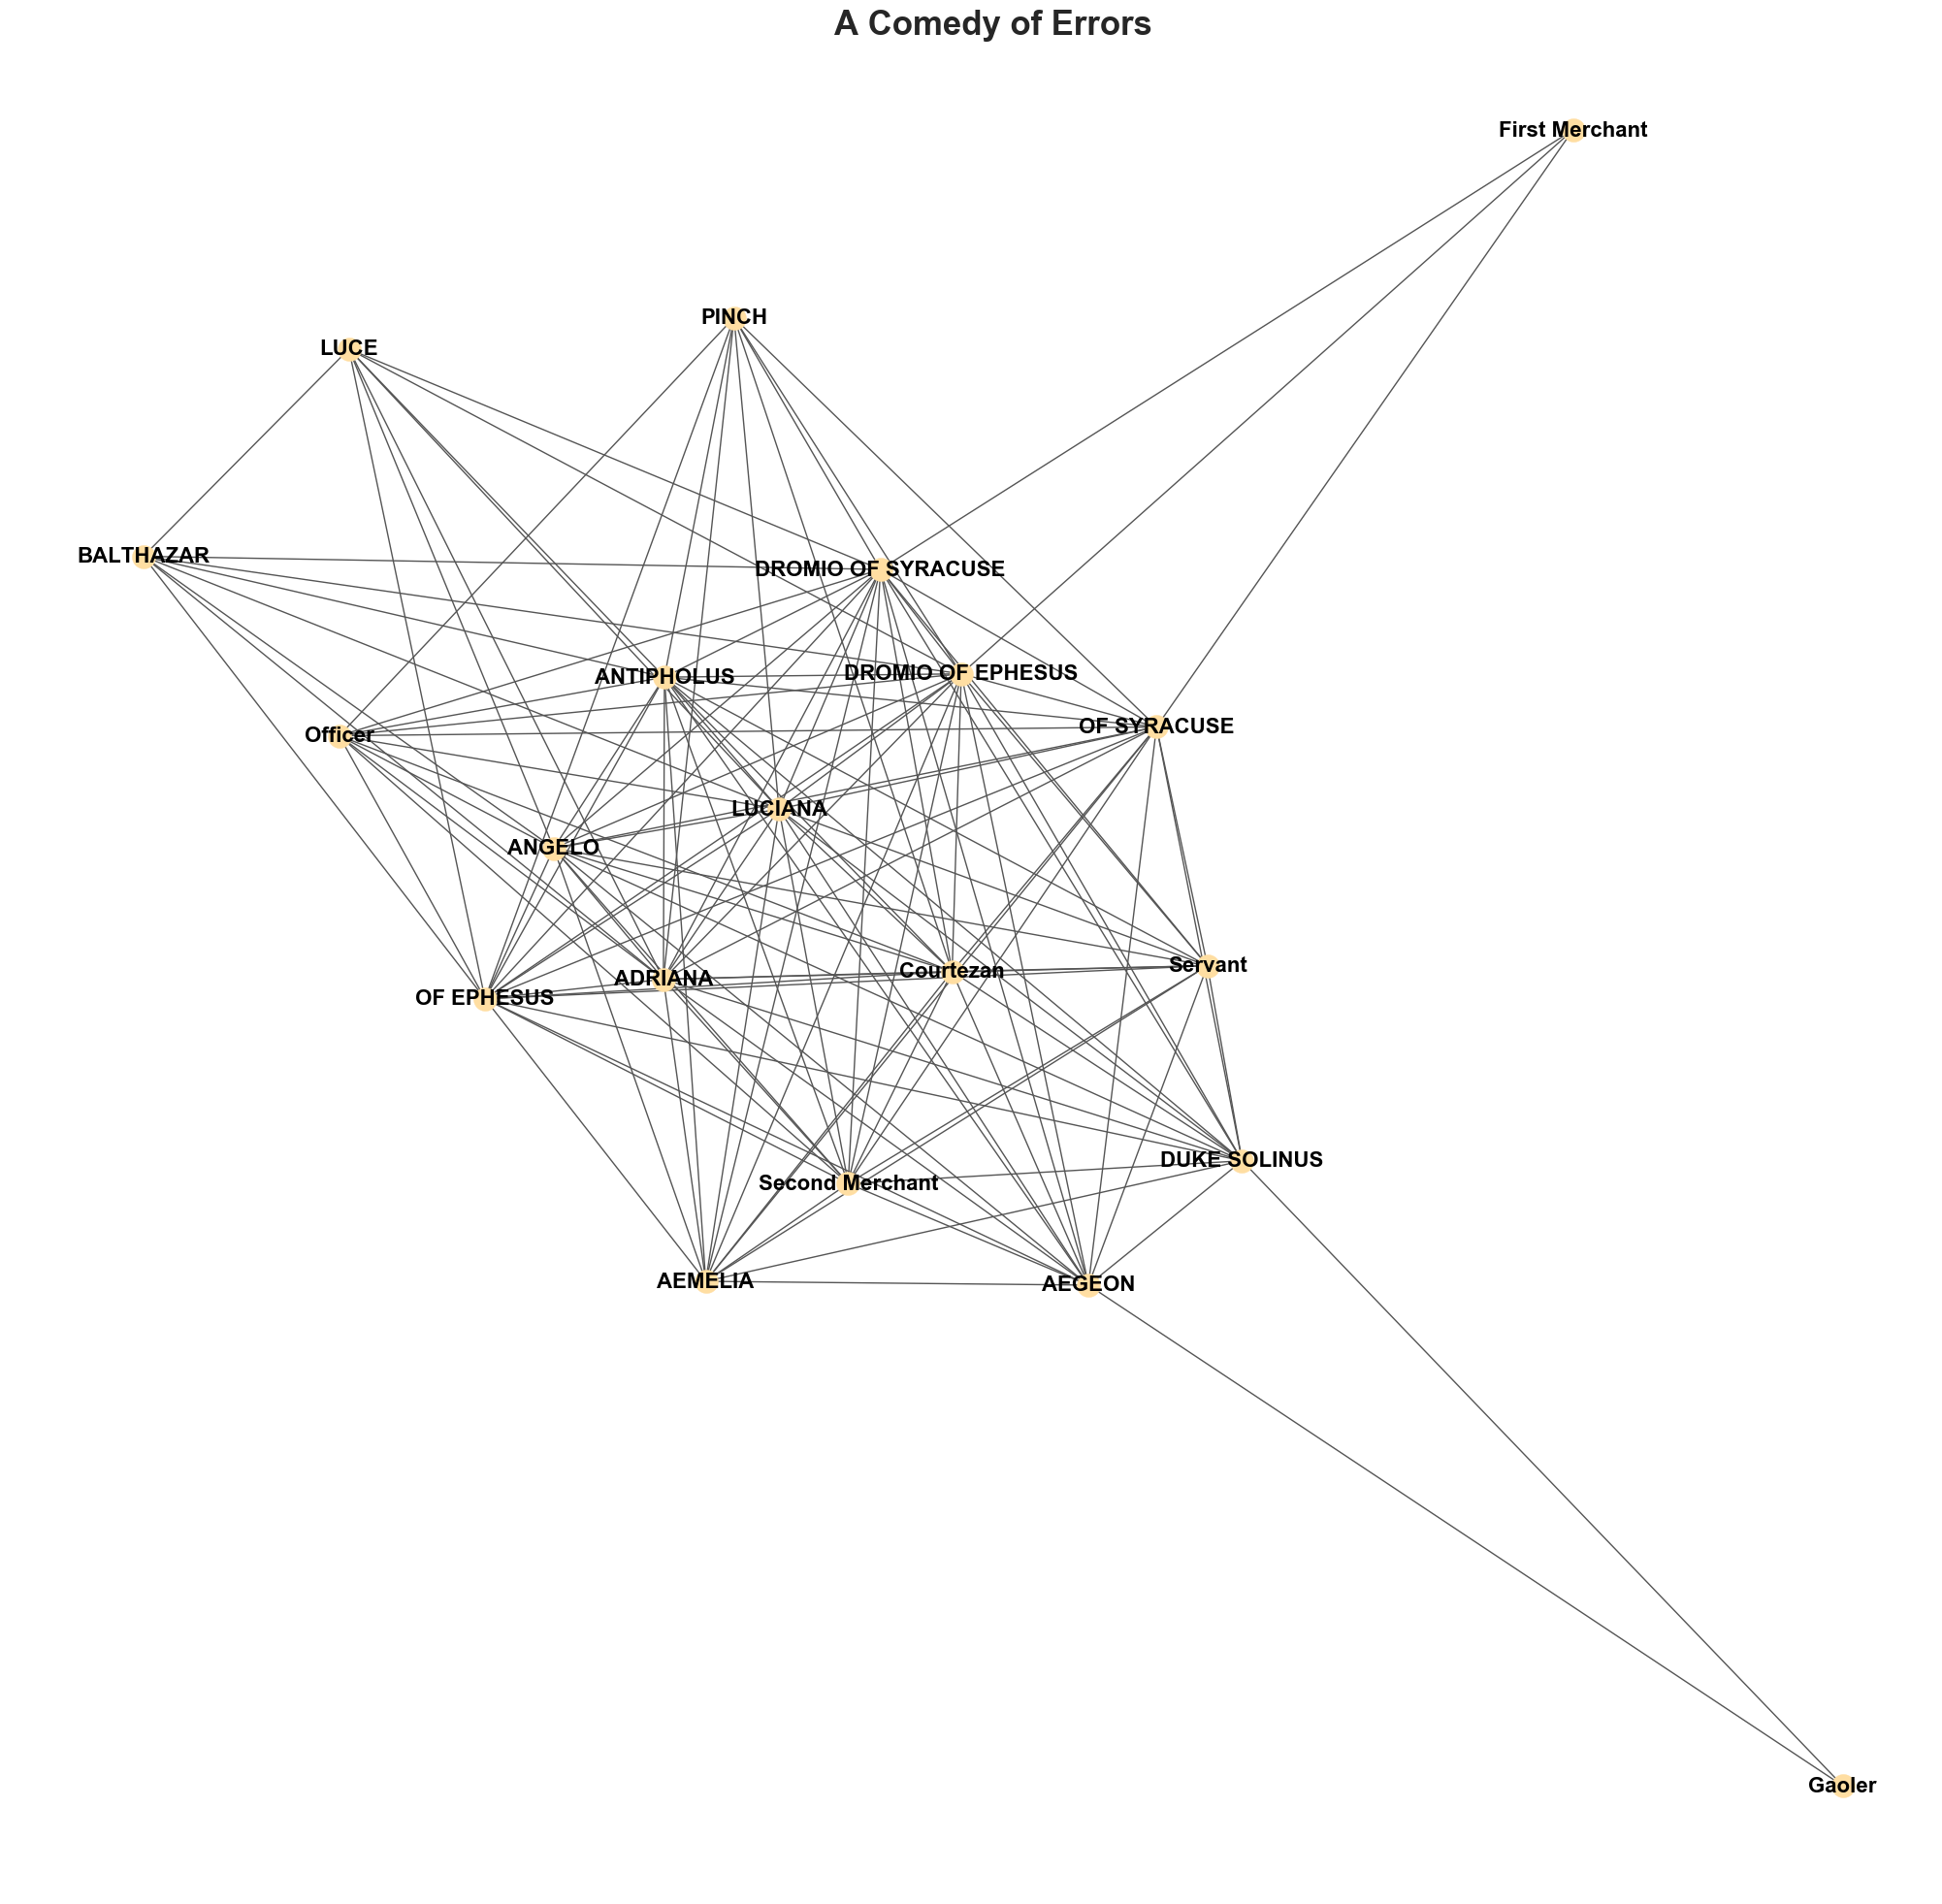

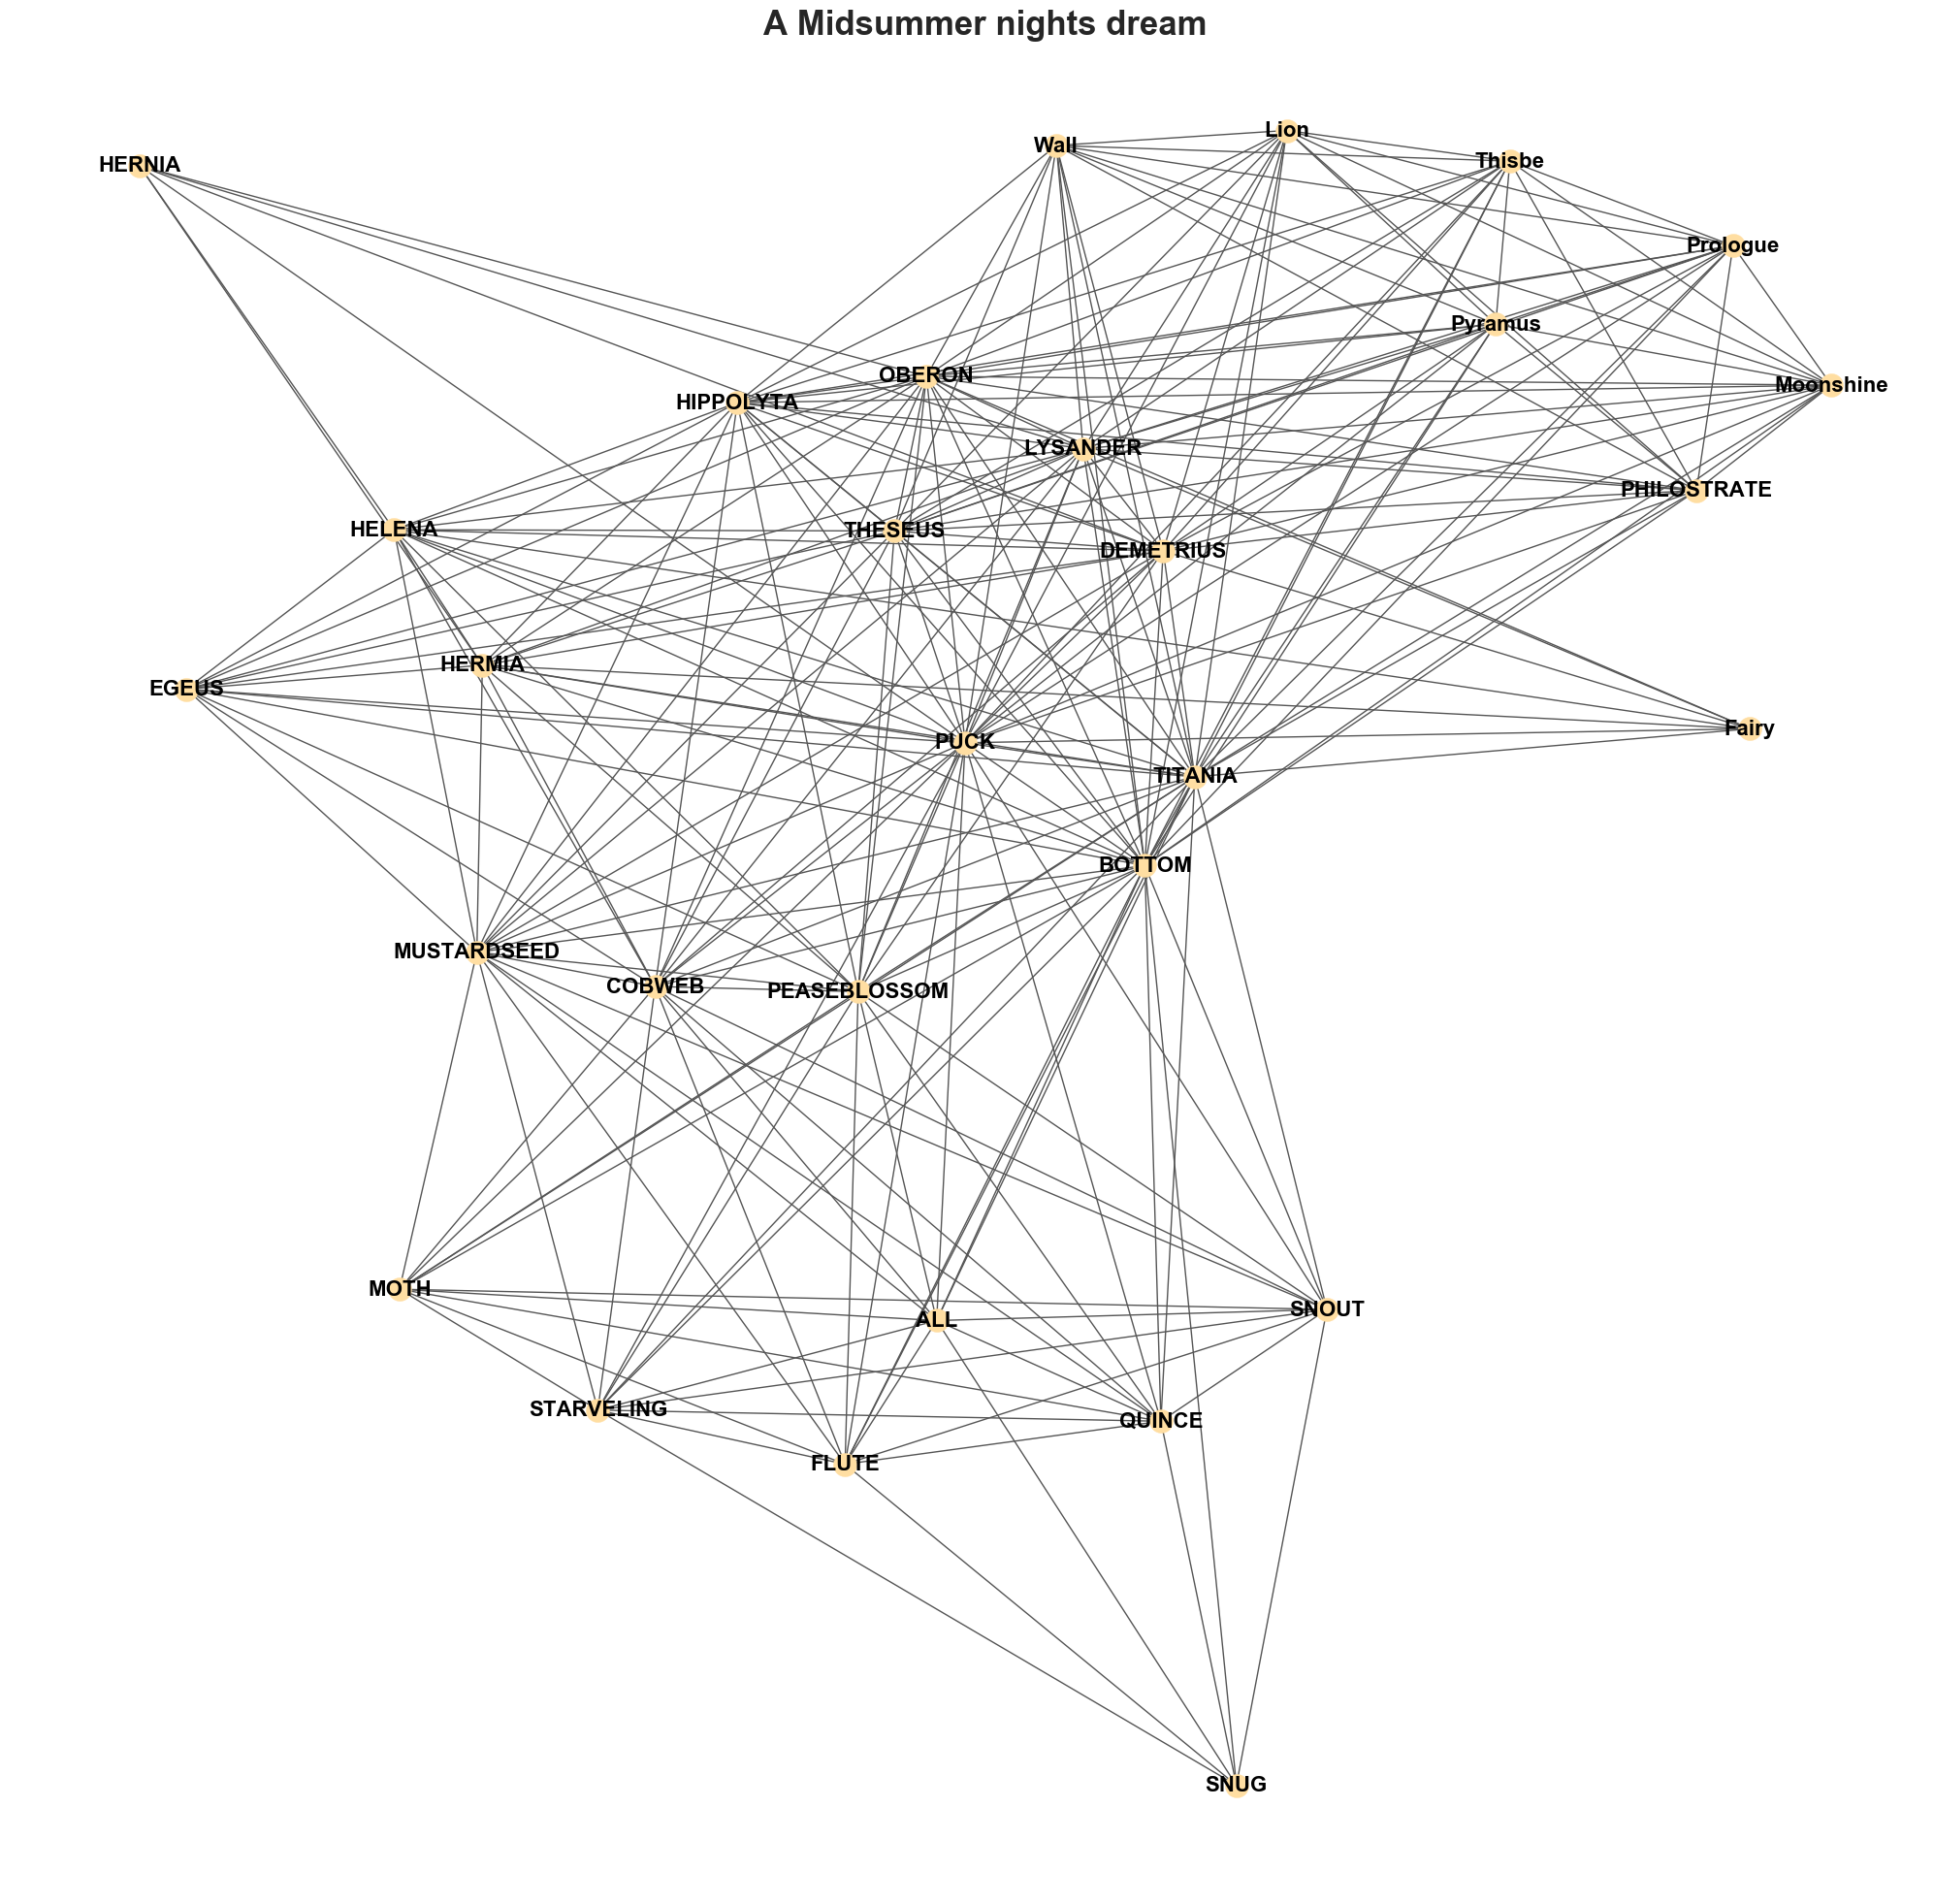

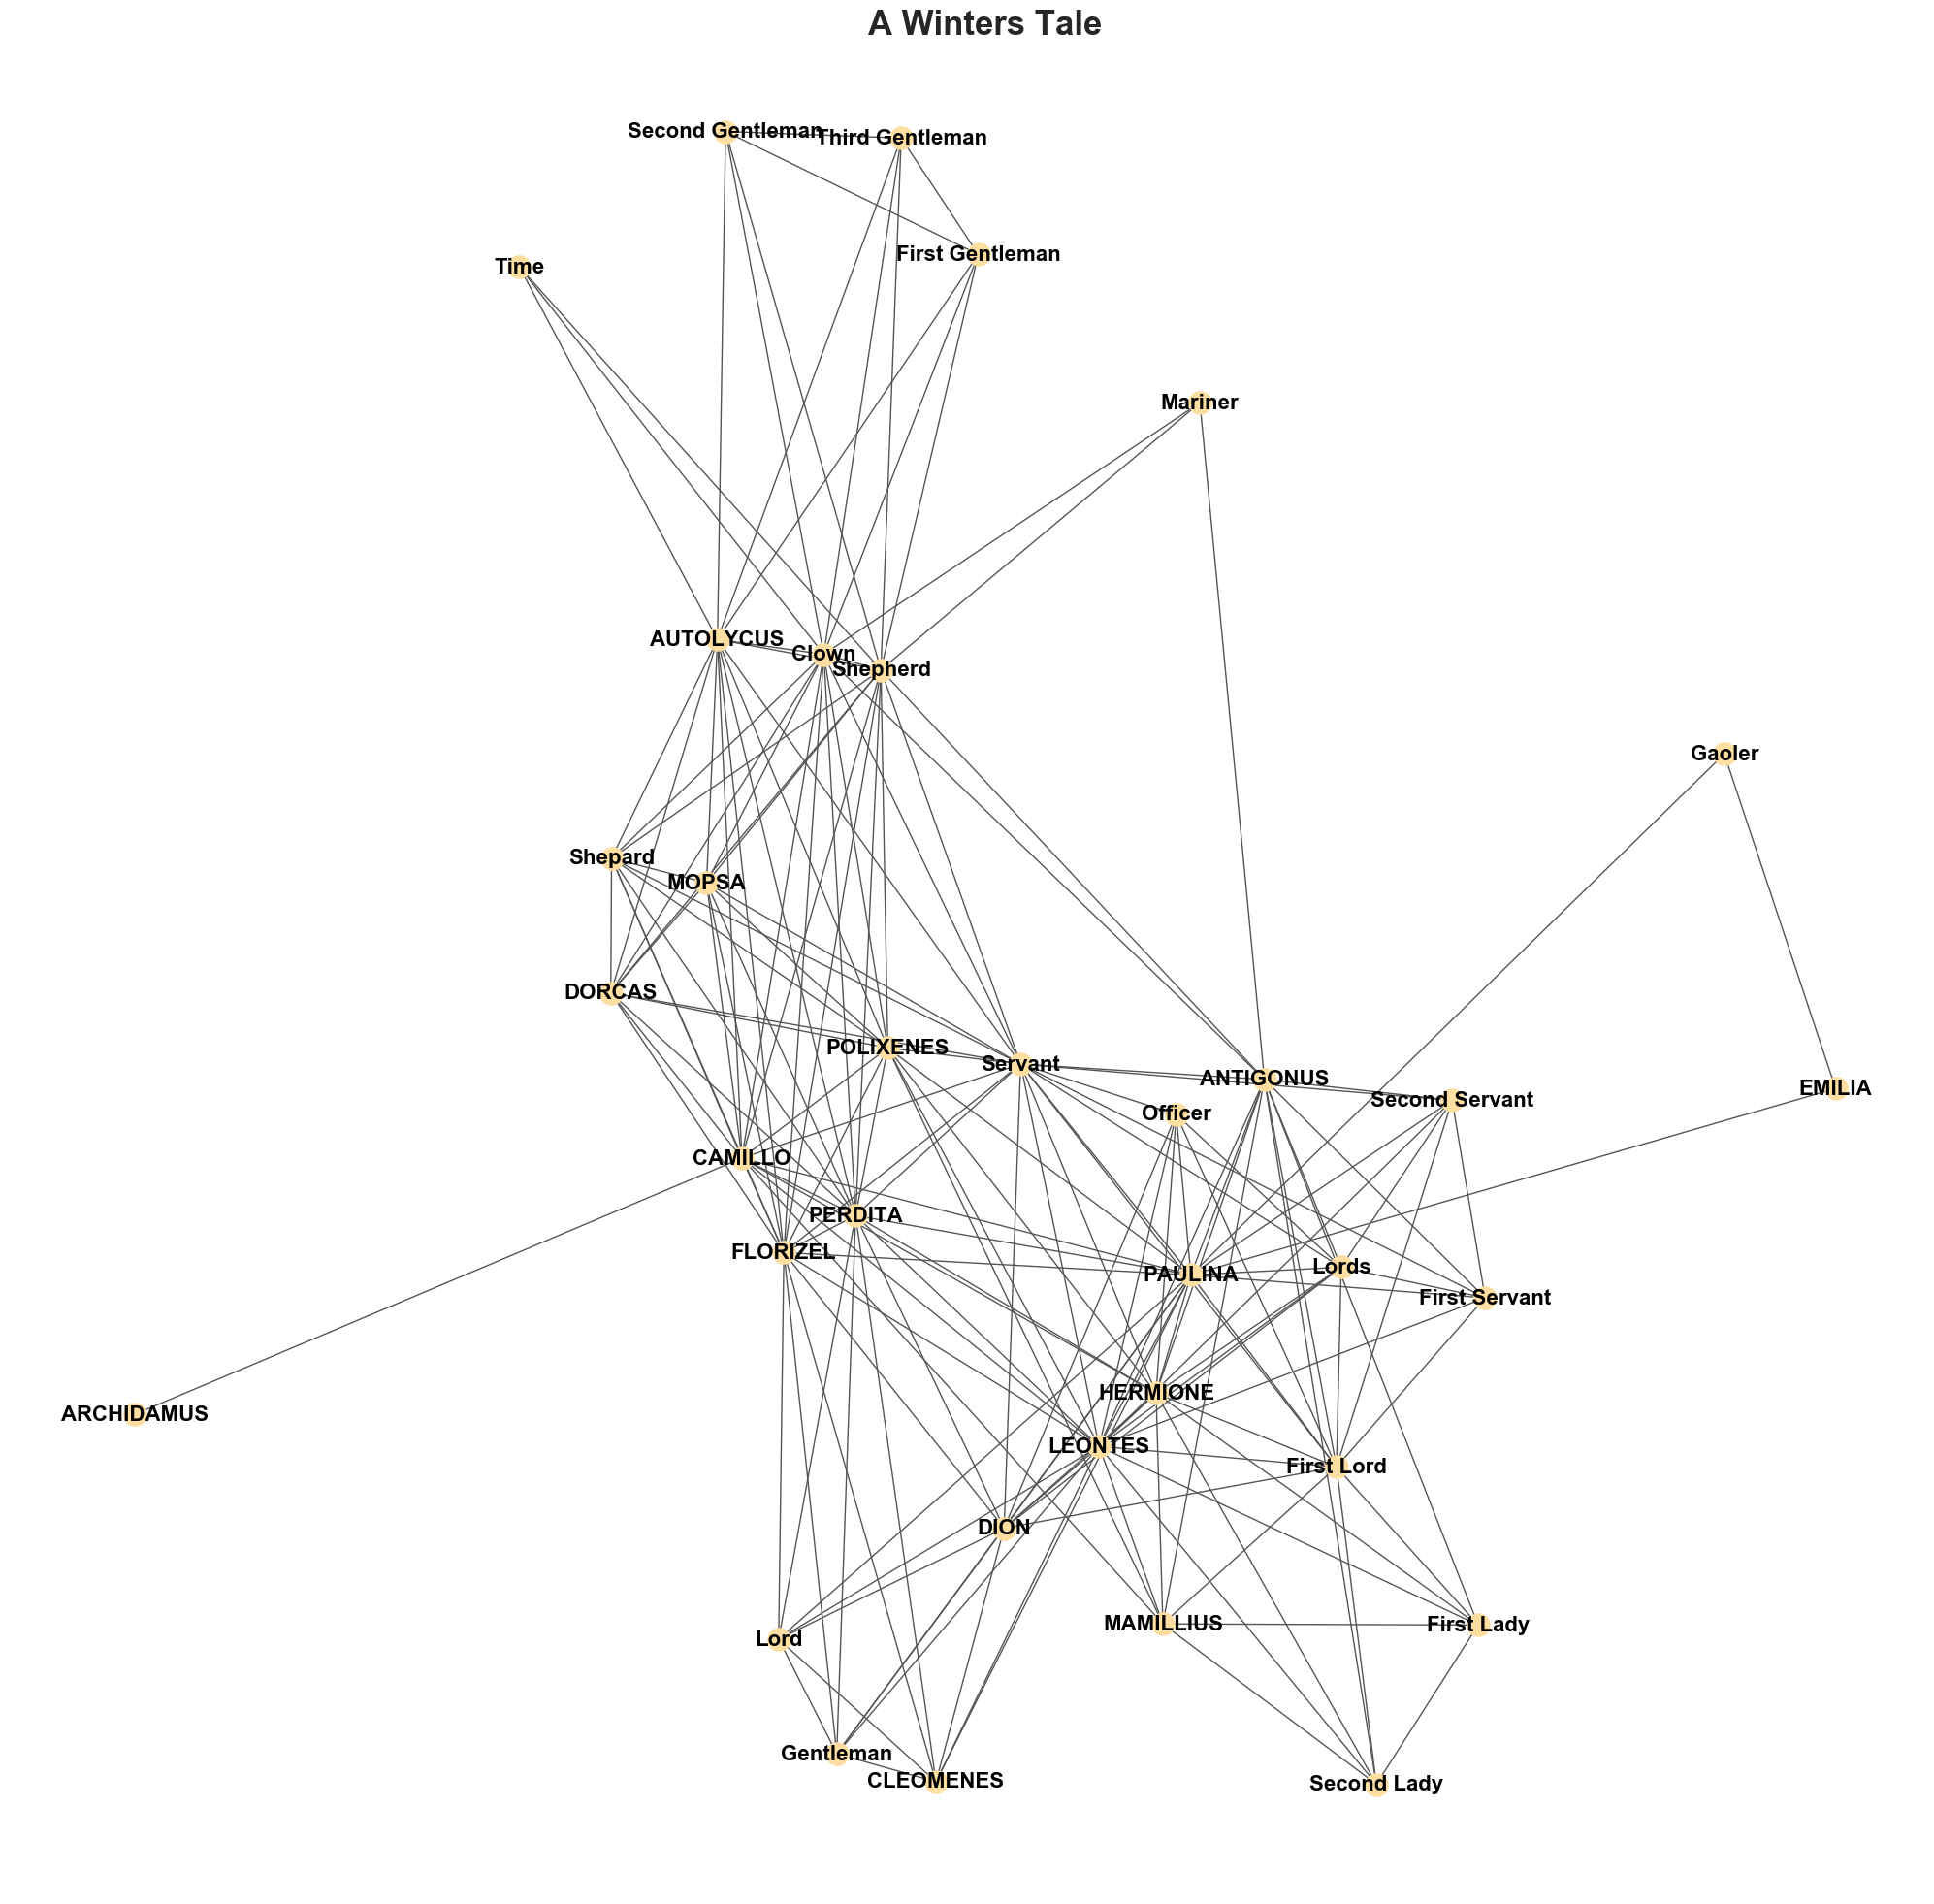

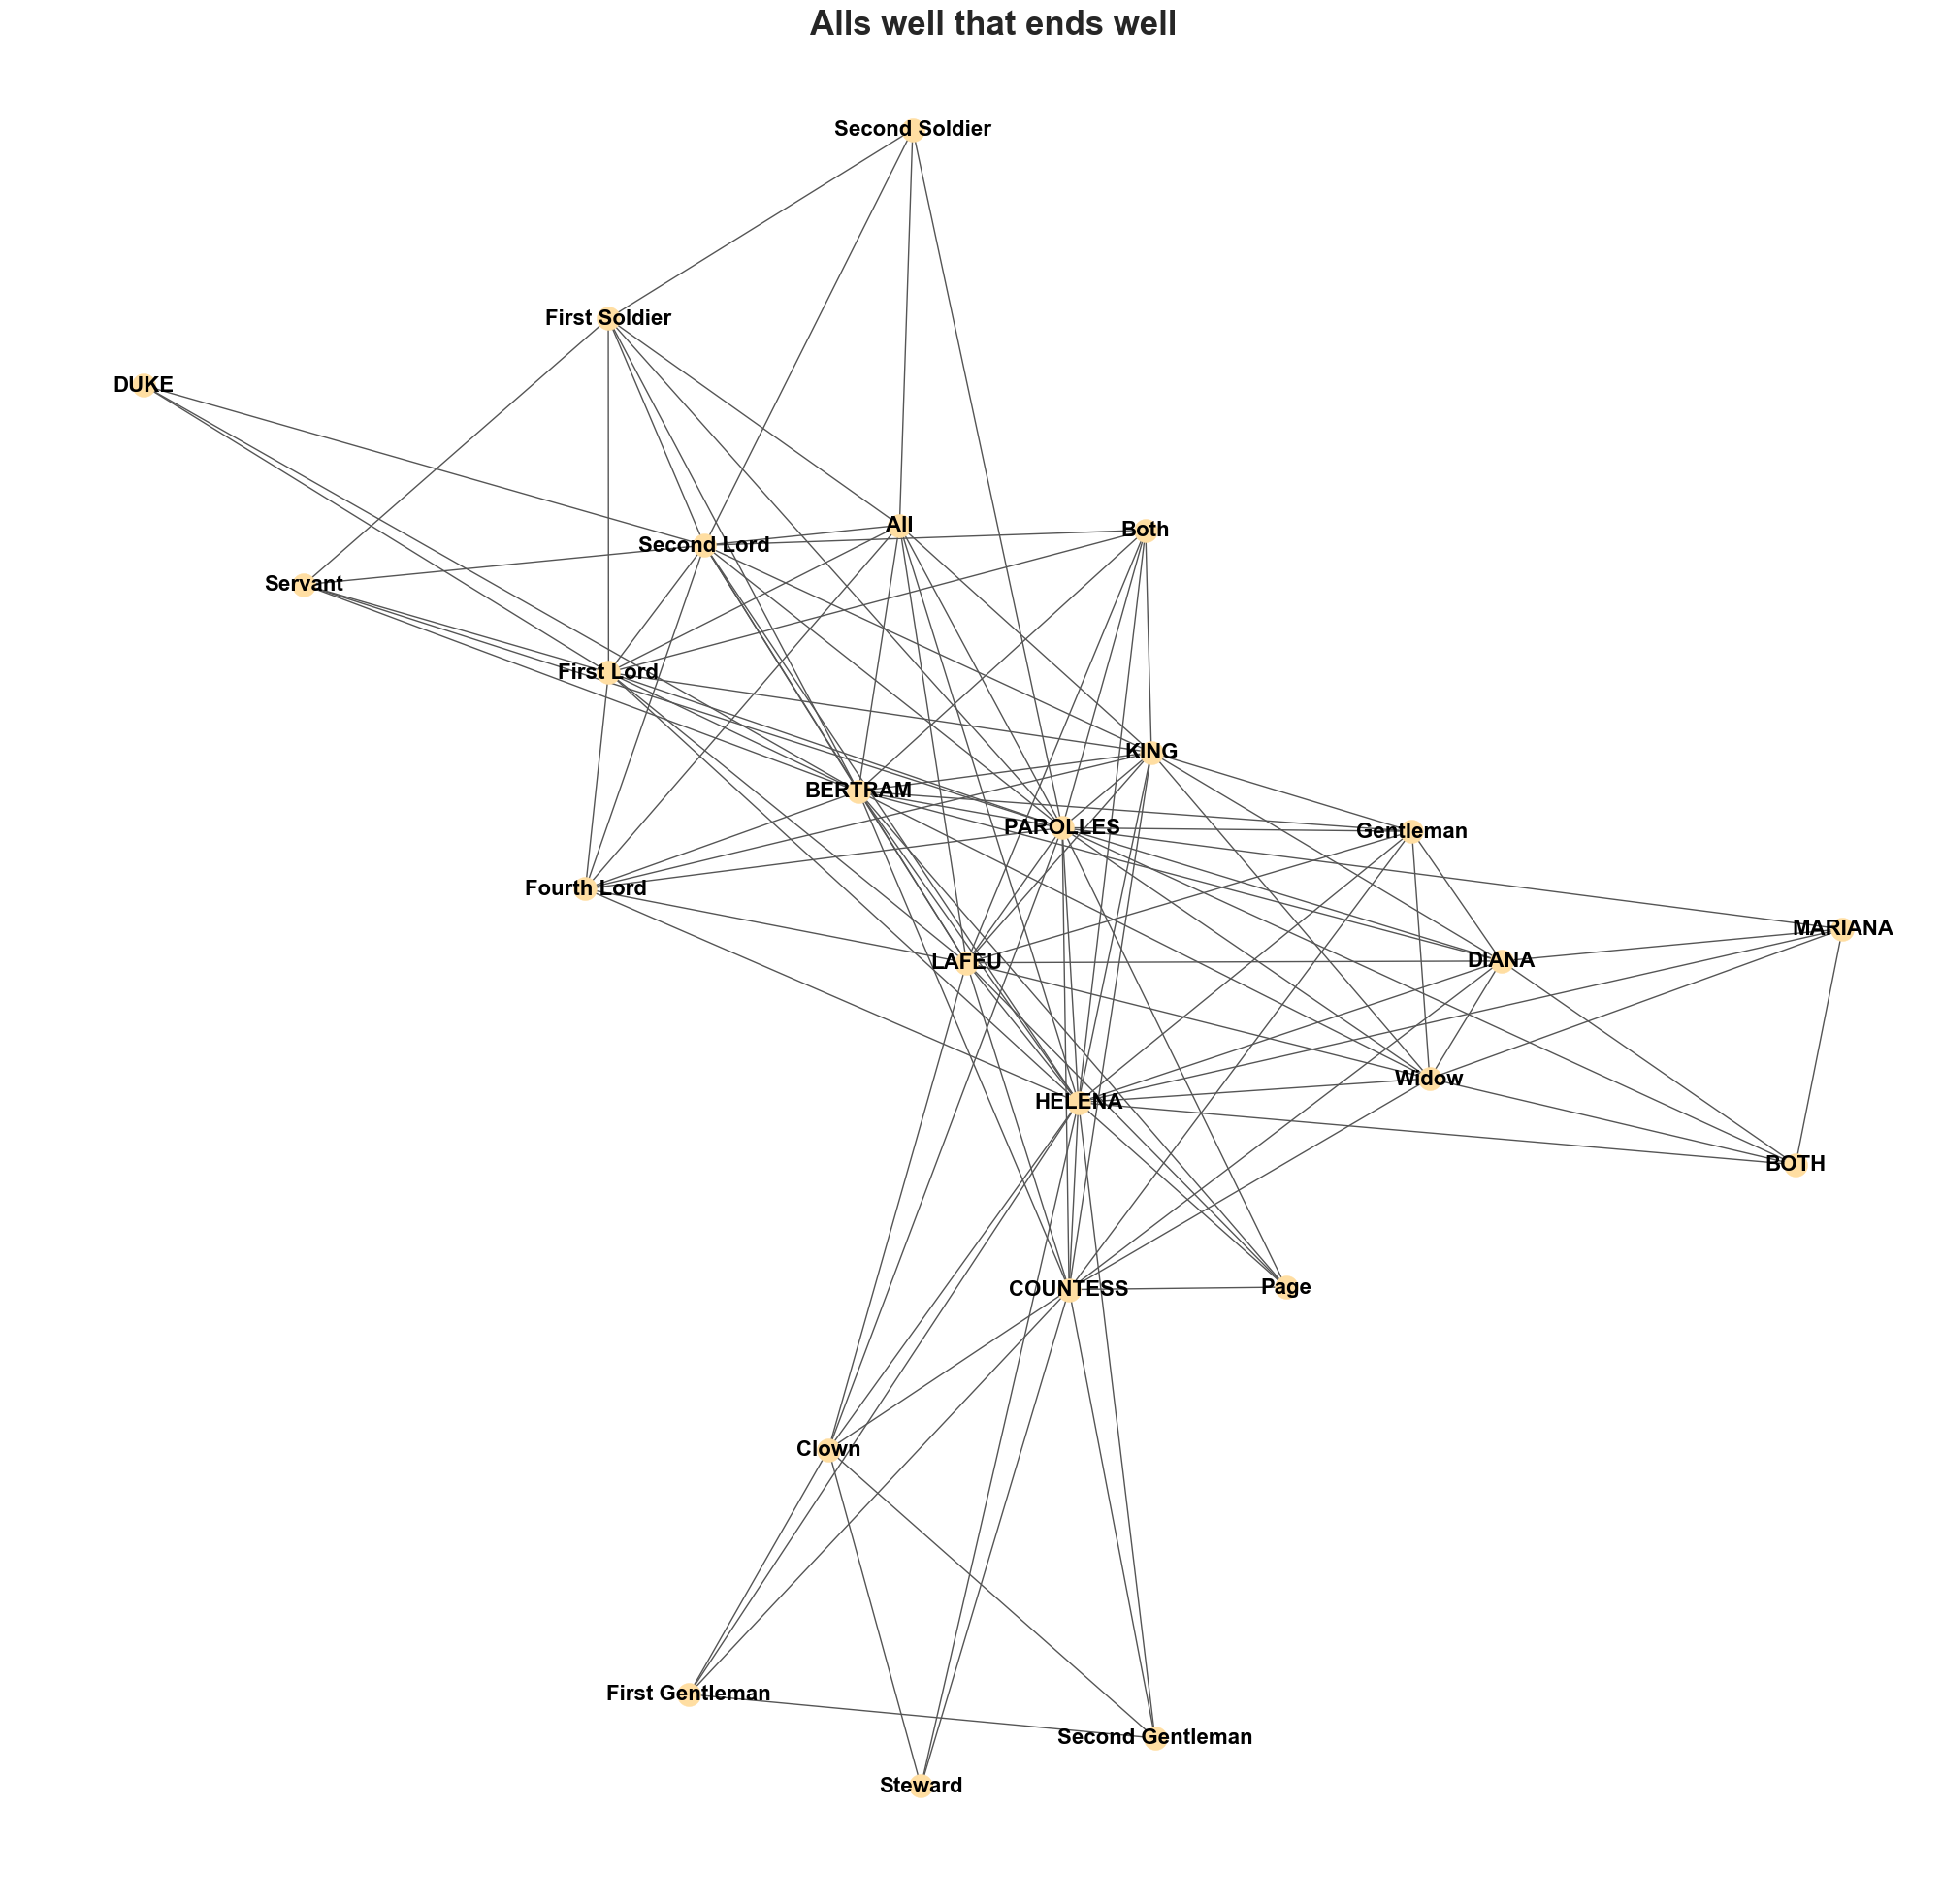

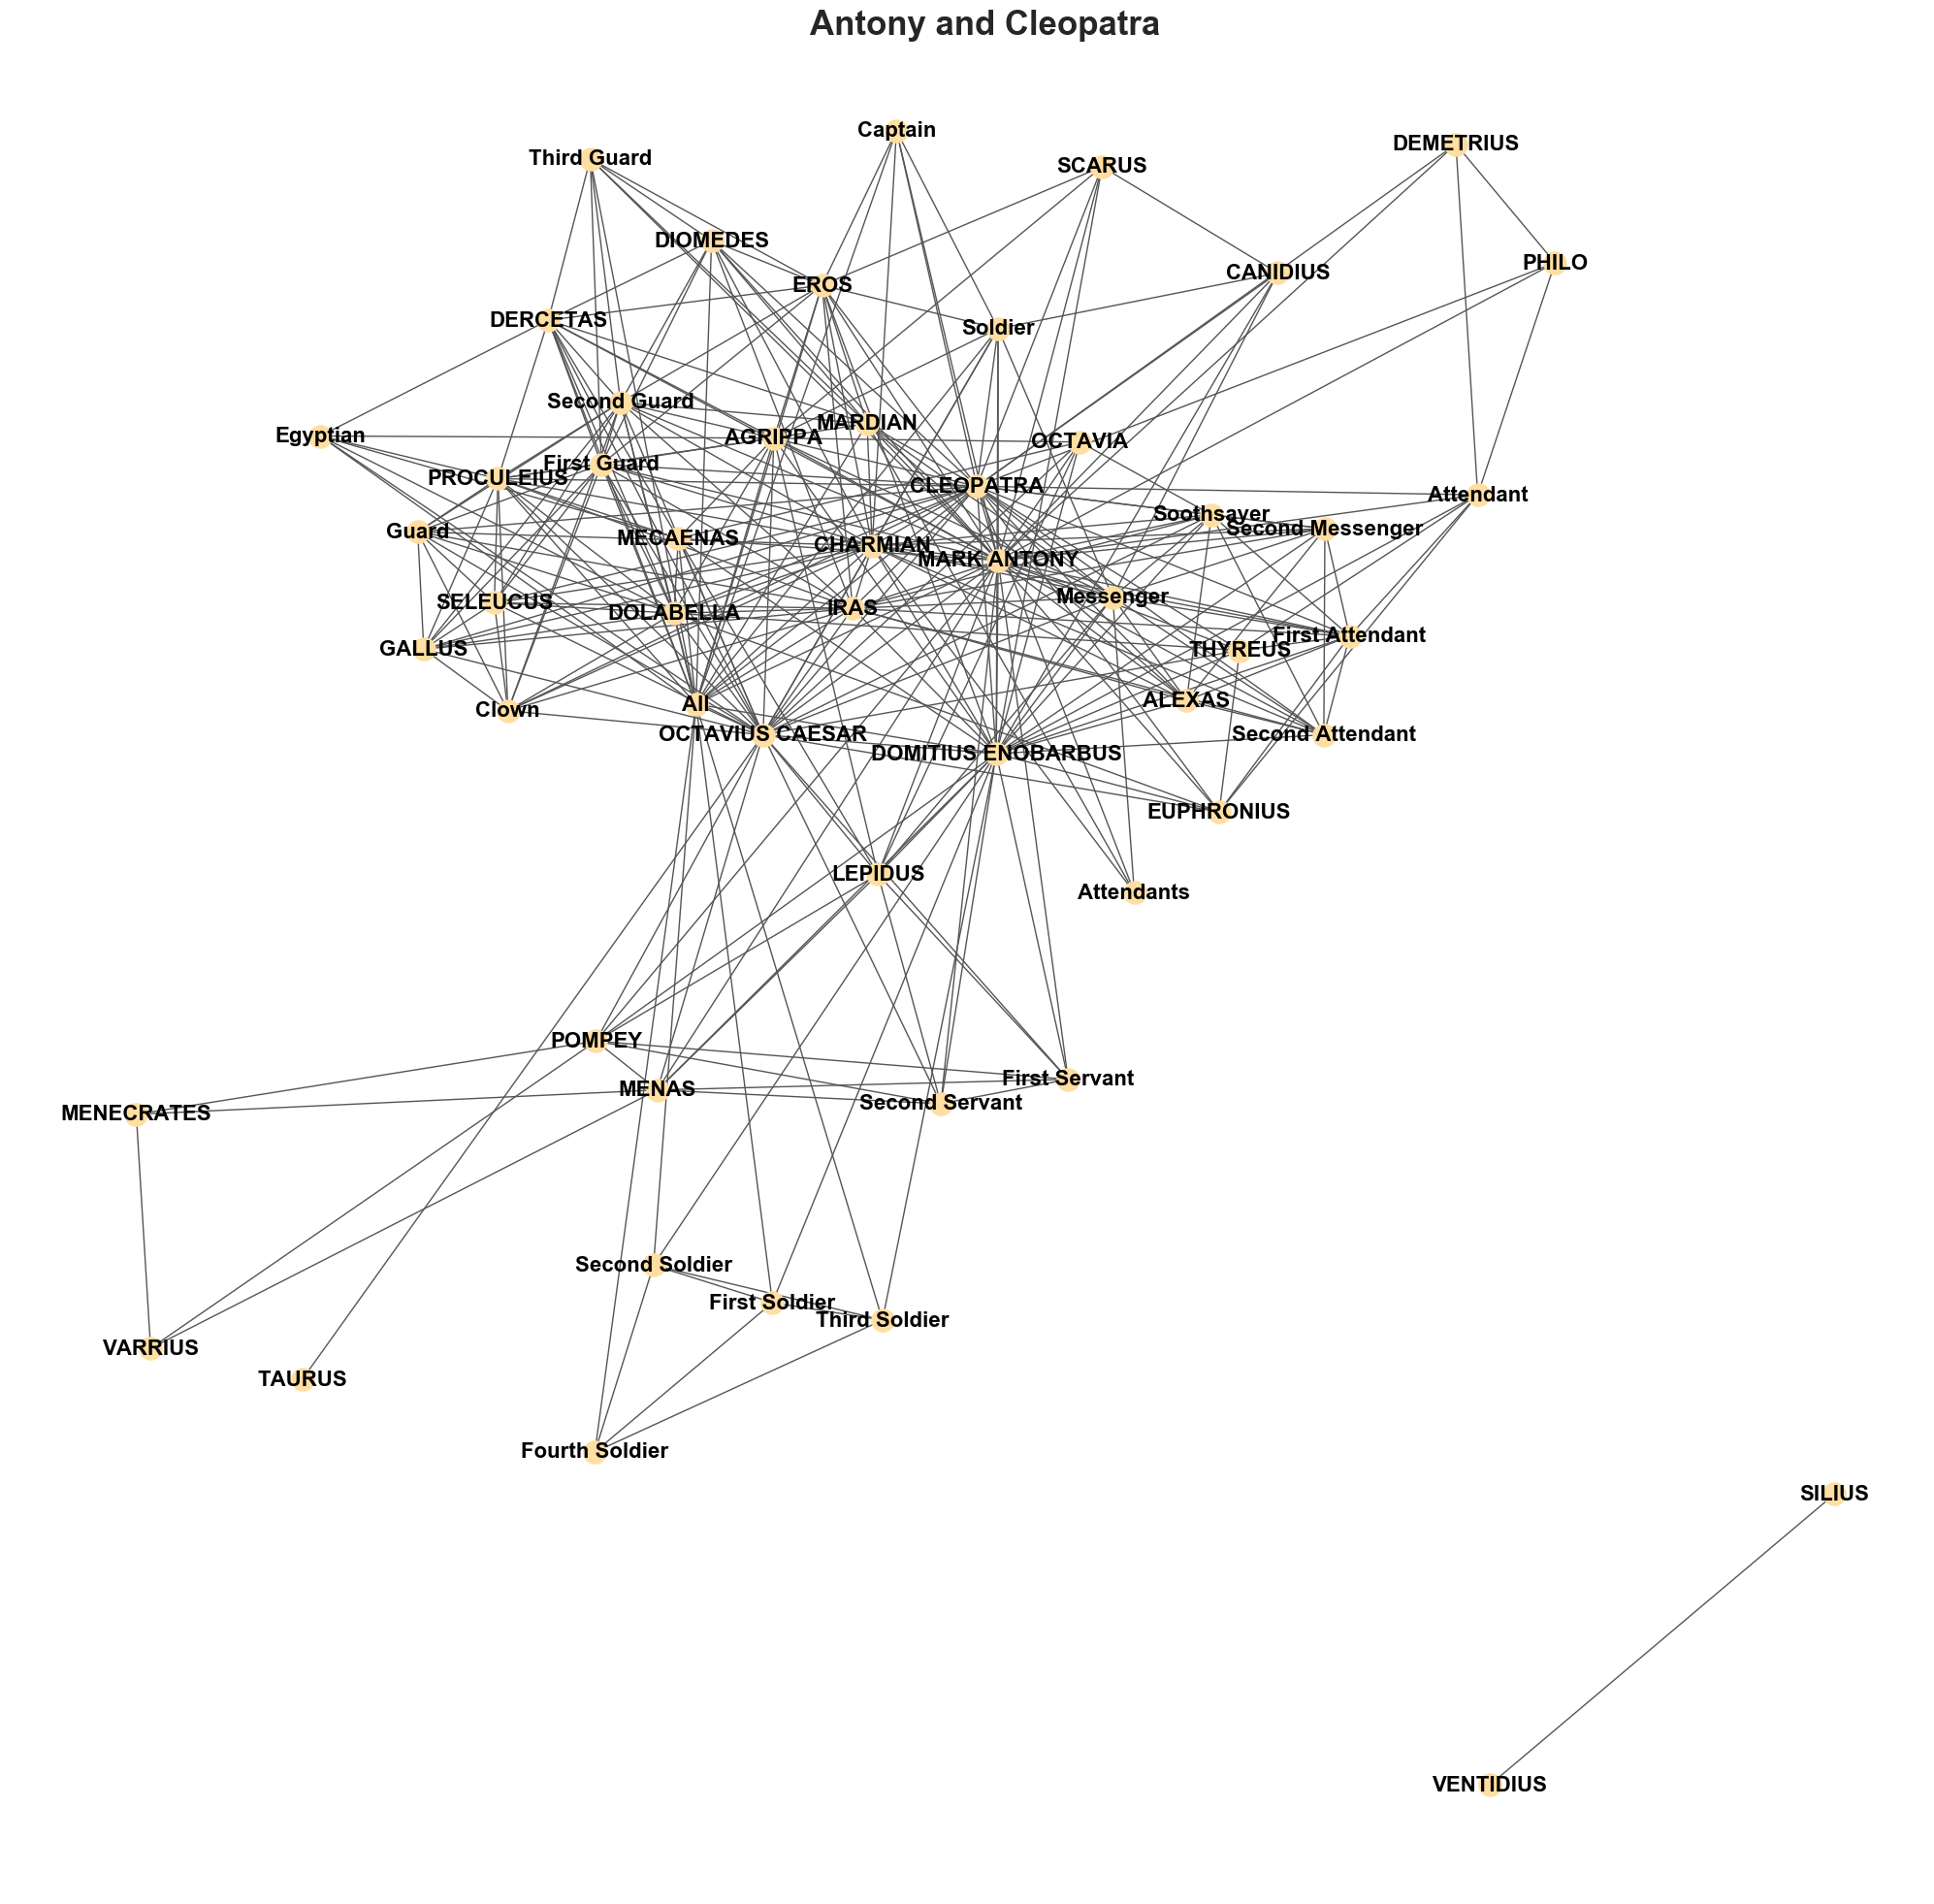

In [14]:
# PLOT A FEW OF THE PLAYS TO MAKE SURE EVERYTHING LOOKS GOOD
row, column = df_Players.shape
for i in range(5):
    plot_network(df_Players['Play'][i], df_Players['Players'][i])

<a id='centralities'></a>
# 8. Create Pandas Frame with Centrality Measures

### Plot the Centrality measures for 1 play first

In [15]:
pairs = pd.DataFrame(df_Players['Players'][i], columns = ['player1', 'player2'])
g = nx.from_pandas_edgelist(pairs,source='player1',target='player2')
centralMeasures = pd.DataFrame(nx.degree_centrality(g),index=[0]).T
centralMeasures.columns=['Degree Centrality']
centralMeasures['Closeness centrality']= pd.DataFrame(nx.closeness_centrality(g),index=[0]).T
centralMeasures['Betweenness centrality']= pd.DataFrame(nx.betweenness_centrality(g),index=[0]).T
centralMeasures['Eigenvector centrality']= pd.DataFrame(nx.eigenvector_centrality(g),index=[0]).T
centralMeasures['Page Rank']= pd.DataFrame(nx.pagerank(g),index=[0]).T
centralMeasures['Name']= centralMeasures.index.tolist()
centralMeasures.index = np.arange(0,len(centralMeasures))
centralMeasures.sort_values(by=['Degree Centrality'], ascending=False).head(15)

Degree Centrality  Closeness centrality  Betweenness centrality  \
2            0.716981              0.743568                0.164808   
1            0.660377              0.691204                0.104020   
14           0.603774              0.681604                0.129643   
8            0.603774              0.681604                0.129691   
5            0.528302              0.629173                0.037944   
34           0.490566              0.613443                0.084136   
9            0.452830              0.598481                0.019920   
43           0.377358              0.570645                0.008392   
35           0.377358              0.570645                0.014002   
44           0.377358              0.570645                0.008392   
10           0.358491              0.557676                0.015652   
29           0.339623              0.551410                0.007412   
49           0.339623              0.557676                0.007830   
22           0.320755              0.551410                0.010926   
46           0.301887              0.545283                0.005987   

    Eigenvector centrality  Page Rank                Name  
2                 0.284521   0.049039         MARK ANTONY  
1                 0.285475   0.044168           CLEOPATRA  
14                0.260592   0.042219     OCTAVIUS CAESAR  
8                 0.229999   0.042653  DOMITIUS ENOBARBUS  
5                 0.258371   0.034170            CHARMIAN  
34                0.218569   0.034059                 All  
9                 0.235902   0.028913                IRAS  
43                0.198289   0.024248         First Guard  
35                0.181417   0.024633           DOLABELLA  
44                0.198289   0.024248        Second Guard  
10                0.169295   0.024241           Messenger  
29                0.170631   0.022557                EROS  
49                0.170901   0.022068          PROCULEIUS  
22                0.143765   0.021807             AGRIPPA  
46                0.142886   0.020075            DERCETAS

### Function to create the centrality dataframe for all the plays

Since there are different number of players in each play. This function provides two options to create the centrality dataframe
It either takes the man of the centrality numbers for each character or it only uses the top 17 characters from each play.
The Method variable can be changed to get one or the other.

In [16]:
# Function to create the centrality dataframe for all the plays
# Method can be 'mean' OR 'top17'
def calculate_centralities(df_Players, Method = 'top17'): 
    row, column = df_Players.shape
    lst_return = []
    player_count = []
    for i in range(row):
        pairs = pd.DataFrame(df_Players['Players'][i], columns = ['player1', 'player2'])
        g = nx.from_pandas_edgelist(pairs,source='player1',target='player2')
        centralMeasures = pd.DataFrame(nx.degree_centrality(g),index=[0]).T
        centralMeasures.columns=['Degree Centrality']
        centralMeasures['Closeness centrality']= pd.DataFrame(nx.closeness_centrality(g),index=[0]).T
        centralMeasures['Betweenness centrality']= pd.DataFrame(nx.betweenness_centrality(g),index=[0]).T
        centralMeasures['Eigenvector centrality']= pd.DataFrame(nx.eigenvector_centrality(g),index=[0]).T
        centralMeasures['Page Rank']= pd.DataFrame(nx.pagerank(g),index=[0]).T
        #centralMeasures['Name']= centralMeasures.index.tolist()
        centralMeasures.index = np.arange(0,len(centralMeasures))

        if Method == 'mean':
                 means = centralMeasures.mean()
                 lst_return.append({'Degree Centrality': means[0], 'Closeness centrality': means[1],#
                                    'Betweenness Centrality': means[2], 'Eigenvector centrality': means[3], 'Page Rank': means[4],
                                  })
   
        elif Method == 'top17':
                centrality_array = centralMeasures[0:17].values.flatten().tolist()
                lst_return.append(centrality_array)
        
        # Create dataframe for character count plot
        character_count, measure_count = centralMeasures.shape
        player_count.append({'Play':df_Players['Play'][i],
                             'Character Count': character_count,
                            })
        
        #print(df_Players['Play'][i])
        #print(centralMeasures.shape)
        #df_return = pd.concat(df_return, centralMeasures)
        #print(centralMeasures.sort_values(by=['Degree Centrality'], ascending=False).head(15))
    return pd.DataFrame(player_count),pd.DataFrame(lst_return)


#CALCULATE CENTRALITIES
df_character_count, df_centralities_mean= calculate_centralities(df_Players, Method='mean')
df_character_count, df_centralities_top17= calculate_centralities(df_Players, Method='top17')


### Plot the number of characters in each play to make sure the centrality measures for the character networks are not too skewed by the number of characters in a play

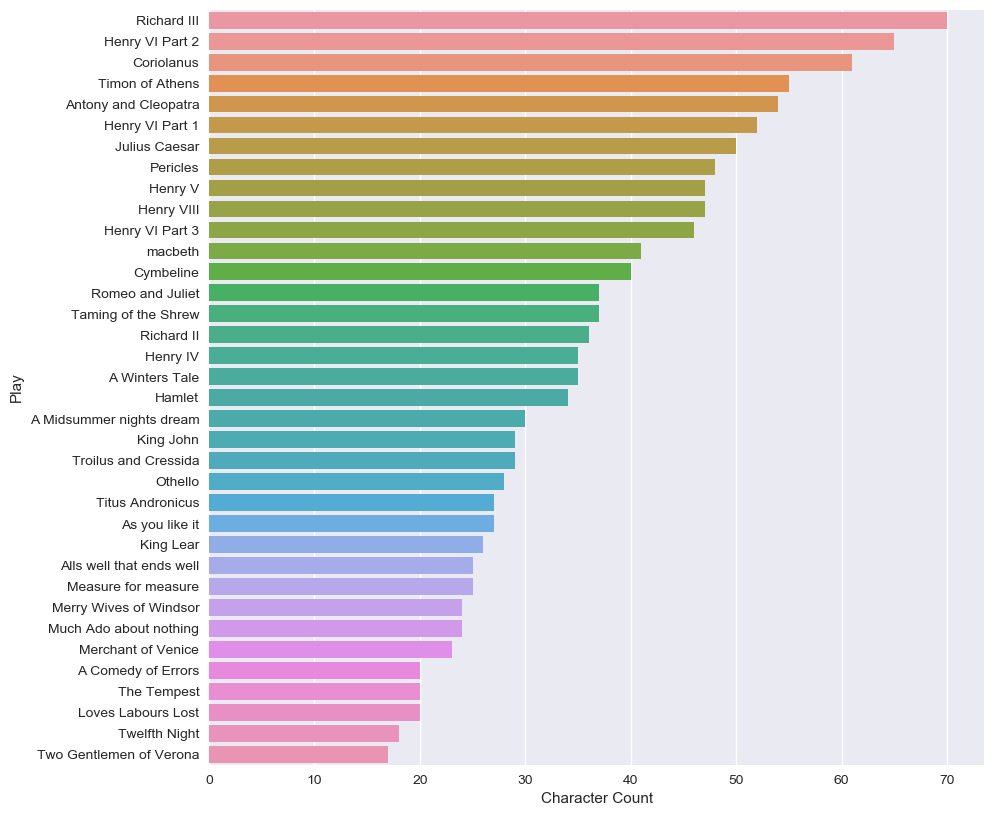

In [17]:
# Print the number of Characters in each Play to make sure the centrality measures are
df_character_count.head()
df_character_count.sort_values(by='Character Count',ascending=False, inplace= True)

plt.figure(figsize=(10,10))
ax = sns.barplot(x='Character Count',y='Play', data= df_character_count)
ax.set(xlabel='Character Count', ylabel='Play')
plt.show()

### The data frame with Player interaction network centrality data for each play using MEAN

In [18]:
print(df_centralities_mean.shape)
df_centralities_mean.head()

(36, 5)


Betweenness Centrality  Closeness centrality  Degree Centrality  \
0                0.019006              0.774816           0.784211   
1                0.016338              0.700980           0.611494   
2                0.027960              0.535484           0.351261   
3                0.029130              0.615134           0.446667   
4                0.015871              0.501565           0.252271   

   Eigenvector centrality  Page Rank  
0                0.212264   0.050000  
1                0.172734   0.033333  
2                0.148645   0.028571  
3                0.179749   0.040000  
4                0.113984   0.018519

### The data frame with Player interaction network centrality data for each play using TOP 17 Players

In [19]:
print(df_centralities_top17.shape)
df_centralities_top17.head()

(36, 85)


0         1         2         3         4         5         6   \
0  0.842105  0.791667  0.049708  0.229608  0.055040  0.842105  0.791667   
1  0.758621  0.763158  0.012931  0.229312  0.039620  0.758621  0.763158   
2  0.088235  0.395349  0.000000  0.019029  0.011199  0.500000  0.641509   
3  0.625000  0.685714  0.061680  0.232373  0.055731  0.791667  0.774194   
4  0.113208  0.462976  0.000000  0.040911  0.009717  0.660377  0.691204   

         7         8         9     ...           75        76        77  \
0  0.049708  0.229608  0.055040    ...     0.684211  0.678571  0.001300   
1  0.012931  0.229312  0.039620    ...     0.310345  0.557692  0.000000   
2  0.088723  0.243171  0.040536    ...     0.352941  0.539683  0.002986   
3  0.095445  0.315501  0.067355    ...     0.250000  0.500000  0.000000   
4  0.104020  0.285475  0.044168    ...     0.245283  0.533429  0.005101   

         78        79        80        81        82        83        84  
0  0.191349  0.043223  0.894737  0.826087  0.007878  0.250298  0.055435  
1  0.090732  0.018386  0.827586  0.805556  0.027216  0.237974  0.043676  
2  0.150505  0.027814  0.647059  0.708333  0.118230  0.308528  0.048813  
3  0.066574  0.024875  0.250000  0.500000  0.000000  0.066574  0.024875  
4  0.092461  0.018172  0.283019  0.533429  0.007358  0.139742  0.019106  

[5 rows x 85 columns]

<a id='isolation'></a>
# 9.  Use Isolation Forest on centrality measures for each play's character network analysis to find outliers that do not resemble the other plays.

In [127]:
#rng = np.random.RandomState(50)
# fit the model
def Fit_isolationForest(data):
        clf = IsolationForest(n_estimators = 1000, max_samples=10, contamination=0.1) 
        #max_samples = The number of samples to draw from X to train each base estimator.
        #contamination = The amount of contamination of the data set, i.e. the proportion
        #of outliers in the data set.
        clf.fit(data)
        y_pred_train = clf.predict(data)
        ind = np.argwhere(y_pred_train==-1)
        return ind
      #print(ind)  
      #print(y_pred_train)

def print_outliers(ind, play_names):
    for p in ind:
        print(play_names['Play'][p].values)
    return


print("OUTLIERS USING MEANS:")
# USING MEAN
print_outliers(Fit_isolationForest(df_centralities_mean), df_Players)

print("\n\nOUTLIERS USING TOP 17 PLAYERS:")    
# USING TOP 17 Players
print_outliers(Fit_isolationForest(df_centralities_top17), df_Players)



OUTLIERS USING MEANS:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


['A Comedy of Errors']
['Loves Labours Lost']
['Twelfth Night']
['Two Gentlemen of Verona']


OUTLIERS USING TOP 17 PLAYERS:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


['A Comedy of Errors']
['Henry V']
['Loves Labours Lost']
['Twelfth Night']


<a id='tsne'></a>
# 10.  TSNE & PCA Plot of Plays based on Player Centralities: Since the data is high dimensional, trying a TSNE and PCA Plot to see if the above Plays show up as far away points compared to the other plays

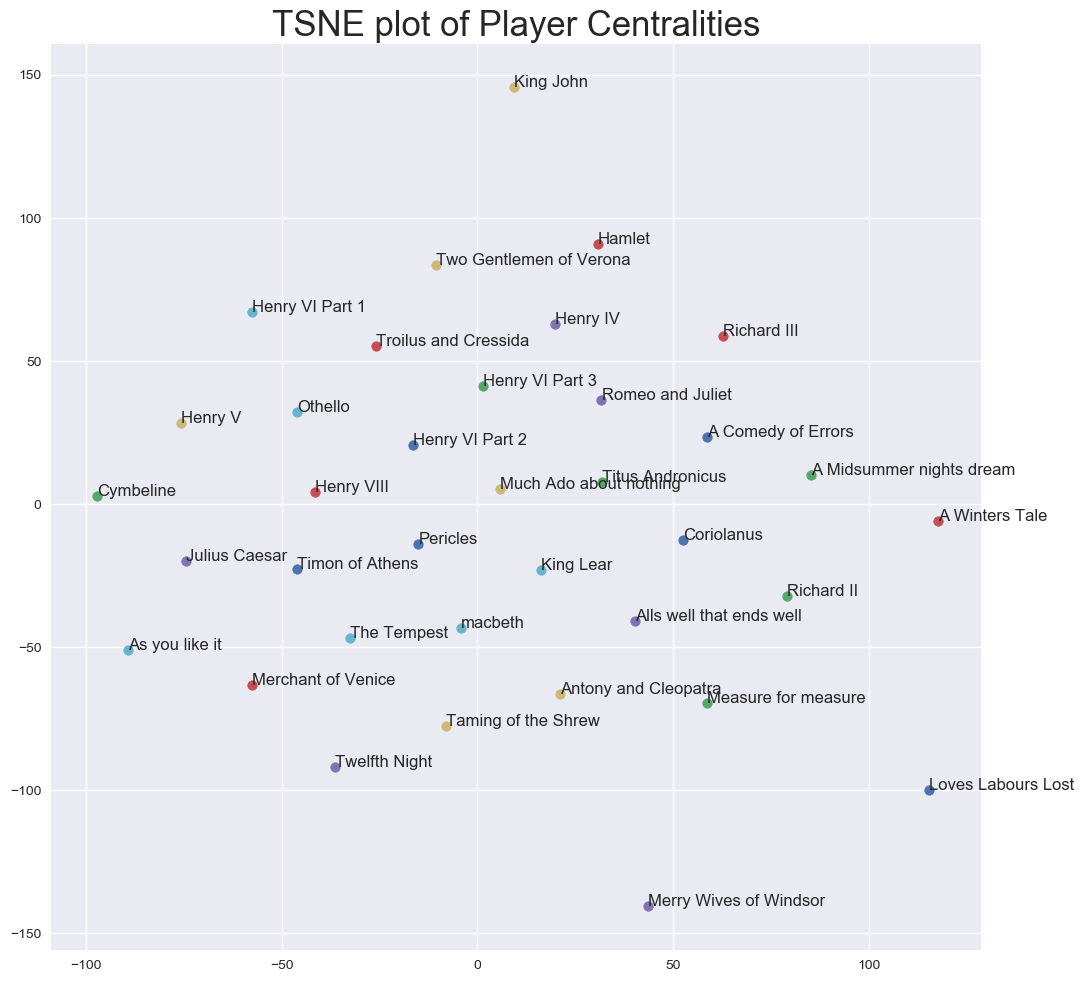

Variance explained by the 2 dimensions:
[0.04477964 0.00038047]


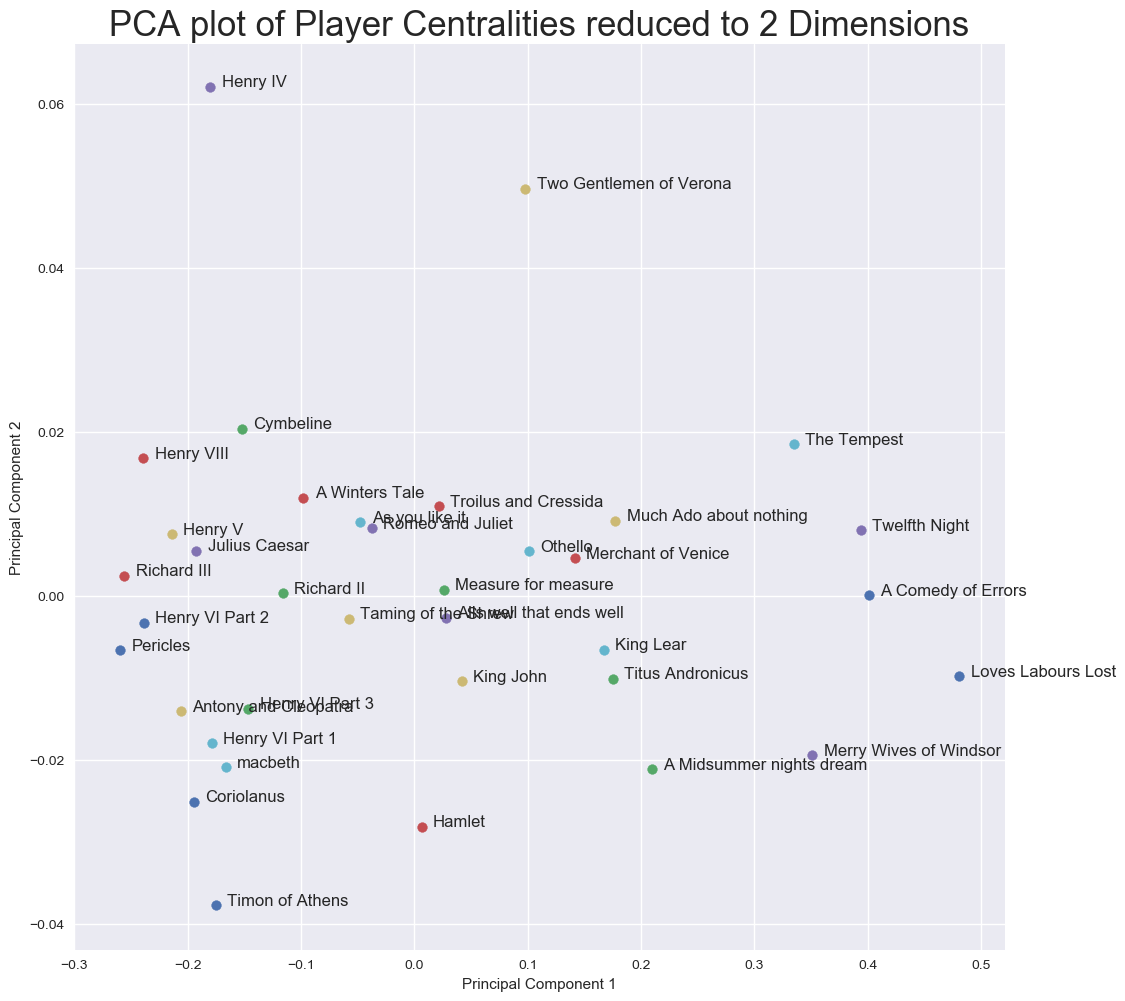

In [59]:
# TSNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(df_centralities_mean.values)
df= df_centralities_top17.copy()
df['x-tsne'] = tsne_results[:,0]
df['y-tsne'] = tsne_results[:,1]
df['x'] = df['x-tsne']
df['y'] = df['y-tsne']

# PLOT
fig, ax = plt.subplots( figsize=(12,12))
for i in range(len(df_Players['Play'].values)):
    ax.scatter(df['x'][i], df['y'][i])
    ax.annotate(df_Players['Play'][i], ((df['x'][i]+0.01), df['y'][i]))
plt.title("TSNE plot of Player Centralities", fontsize = 25)
plt.show()


# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_centralities_mean.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

print ("Variance explained by the 2 dimensions:")
print(pca.explained_variance_)

df['x'] = principalDf ['principal component 1']
df['y'] = principalDf ['principal component 2']

# PLOT
fig, ax = plt.subplots( figsize=(12,12))
for i in range(len(df_Players['Play'].values)):
    ax.scatter(df['x'][i], df['y'][i])
    ax.annotate(df_Players['Play'][i], ((df['x'][i]+0.01), df['y'][i]))
plt.title("PCA plot of Player Centralities reduced to 2 Dimensions", fontsize = 25)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


#### Looking at the TSNE and PCA plots above, I was hoping the Plays that were identified as outliers will show up as outliers in the plots as well.

#### TSNE is inconsistent because of its variations between runs. So it was not of much use in this.

#### The PCA plots are somewhat better and does show plays such as "A Comedy of Errors" , "Loves Labours Lost" and "Twelfth Night" in the outside fringes of the main cluster of plays

#### The explained variance on PCA is very low so it is hard to come up with a conclusion on this PCA Plot

#### With that I can conclude that based on Player interactions alone,"A Comedy of Errors" , "Loves Labours Lost" and "Twelfth Night" are most likely to be plays that had outside contributions other than Shakespear. Now the next step would be to see if looking at usage of key words and analysing the frequencies also come up with some common plays that are in this list generated by analysing the player interactions.

<a id='tfidf'></a>
# 11.  Use TFIDF & CountVectorizers to find frequently used patterns of words and use that to find outliers within the Plays

### This time we look at each Scene to see how many scenes from each play may be outliers compared to all other Scenes from Shakespears plays.

### We focus on 2 letter words or 3 letter words because they are better at finding an authors style in using words in combinations than single words

In [22]:
GROUPING = "Play"  # Change to "Play", "Act" or "Scene" to change what each row should represent

allplays_pipeline = Pipeline([
    ('romove_na', RemoveAllNans()),
    ('split_act_scene_line', split_act_scene_line()),
    ('group_data', group_data(grouping=GROUPING)),
    ('alphanumeric', alphanumeric_lowercase())
])

df_PlayData = allplays_pipeline.fit_transform(df_allPlays)

#df_PlayData['Player'][0]
df_PlayData.head()

Play


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Play  \
0        A Comedy of Errors   
1  A Midsummer nights dream   
2            A Winters Tale   
3  Alls well that ends well   
4      Antony and Cleopatra   

                                             Players  \
0  [(AEGEON, AEGEON), (AEGEON, DUKE SOLINUS), (AE...   
1  [(THESEUS, THESEUS), (THESEUS, THESEUS), (THES...   
2  [(ARCHIDAMUS, ARCHIDAMUS), (ARCHIDAMUS, ARCHID...   
3  [(COUNTESS, BERTRAM), (COUNTESS, BERTRAM), (CO...   
4  [(PHILO, PHILO), (PHILO, PHILO), (PHILO, PHILO...   

                                          PlayerLine  
0  proceed solinus to procure my falland by the d...  
1  now fair hippolyta our nuptial hourdraws on ap...  
2  if you shall chance camillo to visit bohemia o...  
3  in delivering my son from me i bury a second h...  
4  nay but this dotage of our general so erflows ...

### Try using both TFIDF  and CountVectorizer. When using countvectorizer, might need to normalise for Act and Scene sizes.  

In [91]:
# Add a column with the Word Count in each play
row, columns = df_PlayData.shape
line_counts = []
for i in range(row):
    line_counts.append(len(df_PlayData["PlayerLine"][i].split()))
    
df_PlayData["Word_count"] = line_counts
df_PlayData.head()

Play  \
0        A Comedy of Errors   
1  A Midsummer nights dream   
2            A Winters Tale   
3  Alls well that ends well   
4      Antony and Cleopatra   

                                             Players  \
0  [(AEGEON, AEGEON), (AEGEON, DUKE SOLINUS), (AE...   
1  [(THESEUS, THESEUS), (THESEUS, THESEUS), (THES...   
2  [(ARCHIDAMUS, ARCHIDAMUS), (ARCHIDAMUS, ARCHID...   
3  [(COUNTESS, BERTRAM), (COUNTESS, BERTRAM), (CO...   
4  [(PHILO, PHILO), (PHILO, PHILO), (PHILO, PHILO...   

                                          PlayerLine  Word_count  
0  proceed solinus to procure my falland by the d...       14402  
1  now fair hippolyta our nuptial hourdraws on ap...       16033  
2  if you shall chance camillo to visit bohemia o...       23938  
3  in delivering my son from me i bury a second h...       22040  
4  nay but this dotage of our general so erflows ...       23474

In [123]:
# PARAMETERS FOR TFIDF
tfidf = True
min_ngram = 3
max_ngram = 3

max_df = 1.0
min_df = 1.0
max_features = 10

if tfidf == True: 
     vectorizer = TfidfVectorizer(ngram_range=(min_ngram, max_ngram), max_features = max_features, max_df = max_df)
elif tfidf == False:
     vectorizer = CountVectorizer(ngram_range=(min_ngram, max_ngram), max_features = max_features, max_df = max_df)
X = vectorizer.fit_transform(df_PlayData["PlayerLine"])
print(X.get_shape())

(36, 10)


In [124]:
# CONVERT TFIDF RESULTS TO PANDAS DATA FRAME
df_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

# ADD THE YEAR COLUMN TO THE DATAFRAME
df_words['Play'] = df_PlayData['Play']
df_words.head()

good my lord  if it be  it is not  my good lord  my lord and  my lord of  \
0      0.000000  0.364082   0.335397      0.374285     0.374285         0.0   
1      0.000000  0.000000   0.692803      0.193283     0.193283         0.0   
2      0.585053  0.508426   0.093674      0.209070     0.209070         0.0   
3      0.340555  0.177571   0.109054      0.730188     0.425943         0.0   
4      0.404780  0.527646   0.324050      0.542433     0.180811         0.0   

   the duke of  there is no  this is the  what the matter  \
0     0.615762     0.000000     0.309210         0.000000   
1     0.000000     0.193283     0.638710         0.000000   
2     0.000000     0.522674     0.172720         0.000000   
3     0.200214     0.243396     0.100539         0.128691   
4     0.000000     0.000000     0.298748         0.191201   

                       Play  
0        A Comedy of Errors  
1  A Midsummer nights dream  
2            A Winters Tale  
3  Alls well that ends well  
4      Antony and Cleopatra

In [120]:
def Fit_isolationForest(data):
        clf = IsolationForest(n_estimators = 1000, max_samples=10, contamination=0.3) 
        #max_samples = The number of samples to draw from X to train each base estimator.
        #contamination = The amount of contamination of the data set, i.e. the proportion
        #of outliers in the data set.
        clf.fit(data)
        y_pred_train = clf.predict(data)
        ind = np.argwhere(y_pred_train==-1)
        return ind

def print_outliers(ind, play_names):
    for p in ind:
        print(play_names['Play'][p].values)
    return

print("OUTLIERS:")
# USING MEAN
print_outliers(Fit_isolationForest(df_words.drop('Play', axis=1)), df_words)
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


['A Comedy of Errors']
['As you like it']
['Henry V']
['Henry VI Part 1']
['Henry VI Part 2']
['Henry VIII']
['Julius Caesar']
['Measure for measure']
['Pericles']
['The Tempest']
['Two Gentlemen of Verona']


## SInce there is big difference in the number of words in each play I try to normalise the count vectorizers because TFIDF normalises for the entire corpus but not the documents themselves.

In [125]:
df_words.drop('Play', axis =1, inplace=True)
df_words = df_words.div(df_PlayData['Word_count'].values,axis=0)
df_words['Play'] = df_PlayData['Play']
print("OUTLIERS:")
print_outliers(Fit_isolationForest(df_words.drop('Play', axis=1)), df_words)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


['A Comedy of Errors']
['A Midsummer nights dream']
['Henry V']
['Henry VI Part 1']
['Henry VI Part 2']
['Henry VIII']
['Julius Caesar']
['Pericles']
['The Tempest']
['Twelfth Night']
['Two Gentlemen of Verona']


## We see some of the same plays such as "A Comedy of Errors"  and "Twelfth Night" showing up as outliers with this term frequency analysis. This shows that if some of Shakespears plays where indeed written in colaboration with other authors these are most likely to be the ones.

## Given some more time it would have been interesting to analyse the distance between commonly used phrases and use those to compare between plays. That might be a better way to determine an authors signature writing style.